In [64]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [65]:
data = pd.read_csv("./data/data_frame_smooth.csv")
features = ["ax", "ay", "az", "vel_x", "vel_y", "vel_z", "gx", "gy", "gz", "q0", "q1", "q2", "q3"]
labels = ["dx", "dy"]

data['dx'] = data['x'] - data['x'].shift(1)
data['dy'] = data['y'] - data['y'].shift(1)
# introduces NaN values in the beginning
data['dx'] = data['dx'].fillna(0)
data['dy'] = data['dy'].fillna(0)

scaler = StandardScaler() 
data[features] = pd.DataFrame(scaler.fit_transform(data[features].values), index=data.index)

print(data.head(), len(data))

# todo turn x,y values into cm not pixels or whatever this is

   Unnamed: 0  t_r           x           y    z        ax        ay        az  \
0           0  0.0  171.081563  175.444042  0.0 -0.496755 -3.093995  1.890260   
1           1  0.5  170.148674  174.619624  0.0 -0.899707 -4.329133  1.377966   
2           2  1.0  169.290593  173.889512  0.0 -1.257112 -5.272743  0.990354   
3           3  1.5  168.504520  173.249715  0.0 -1.342064 -4.472514  1.348558   
4           4  2.0  167.787657  172.696245  0.0 -1.415803 -3.668196  1.595401   

         gx        gy  ...    nav_ay    nav_az     vel_x     vel_y     vel_z  \
0  0.045052 -0.245010  ... -0.256070 -0.643924  0.644370  2.381587 -0.227681   
1 -0.599859 -0.118527  ... -0.354587 -0.658915  0.644314  2.381542 -0.227796   
2 -1.064092 -0.028218  ... -0.417381 -0.650395  0.644264  2.381485 -0.227911   
3 -0.447566 -0.154293  ... -0.398371 -0.645887  0.644213  2.381425 -0.228025   
4  0.034074 -0.218649  ... -0.375734 -0.645659  0.644158  2.381367 -0.228139   

        pos_x       pos_y     po

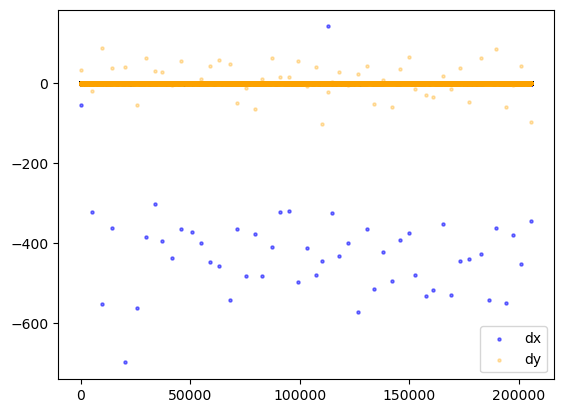

In [66]:
# (n_batches, n_timestemps, n_features)
plt.scatter(range(len(data)), data.dx, c="blue", label= "dx", s=5, alpha=0.5)
plt.scatter(range(len(data)), data.dy, c="orange", label= "dy", s=5, alpha=0.3)
plt.legend()
plt.show()

In [67]:
column_indices = {name: i for i, name in enumerate(data.columns)}
feature_data = data[data.columns.intersection(features+labels)]

n = len(data)
train_data = feature_data[0:int(n*0.8)]
#val_data = feature_data[int(n*0.7):int(n*0.9)]
test_data = feature_data[int(n*0.8):]

num_features = feature_data.shape[1] - len(labels)


In [68]:
train_data.head()


,ax,ay,az,gx,gy,gz,q0,q1,q2,q3,vel_x,vel_y,vel_z,dx,dy
0,-0.496755,-3.093995,1.890260,0.045052,-0.245010,-2.661870,1.569316,0.504605,0.993362,-0.519095,0.644370,2.381587,-0.227681,0.000000,0.000000
1,-0.899707,-4.329133,1.377966,-0.599859,-0.118527,-2.358232,1.543771,0.368381,1.053295,-0.580603,0.644314,2.381542,-0.227796,-0.932889,-0.824417
2,-1.257112,-5.272743,0.990354,-1.064092,-0.028218,-1.957751,1.539405,0.319351,1.057644,-0.610075,0.644264,2.381485,-0.227911,-0.858081,-0.730112
3,-1.342064,-4.472514,1.348558,-0.447566,-0.154293,-0.977974,1.549974,0.340845,1.031174,-0.617444,0.644213,2.381425,-0.228025,-0.786073,-0.639797
4,-1.415803,-3.668196,1.595401,0.034074,-0.218649,-0.212959,1.557015,0.386295,1.005853,-0.616538,0.644158,2.381367,-0.228139,-0.716863,-0.553470


In [69]:
# Prepare the training data
x_train = []
y_train = []

steps = 10
offset = 5

num_batches = int(feature_data.shape[0] / (steps * (num_features)))
i = 0
for b in range(num_batches):
    x_train.append(np.array(train_data.iloc[i: i+steps, :-2]).flatten())
    y_train.append(np.array(train_data.iloc[i:i+steps, -2:]).flatten())
    i = i + offset
x_train, y_train = np.array(x_train).reshape(-1,steps, num_features), np.array(y_train).reshape(-1,steps, len(labels))
print(x_train.shape, y_train.shape)



(1583, 10, 13) (1583, 10, 2)


In [70]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)


    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state

    
    FeedBack.warmup = warmup


    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the LSTM state.
        prediction, state = self.warmup(inputs)

        # Insert the first prediction.
        predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                    training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

    FeedBack.call = call




In [71]:
feedback_model = FeedBack(units=32, out_steps=5)
prediction, state = feedback_model.warmup(x_train)
prediction.shape


TensorShape([1583, 13])

In [72]:
print('Output shape (batch, time, features): ', feedback_model(x_train).shape)

Output shape (batch, time, features):  (1583, 5, 13)


In [75]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')
feedback_model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.keras.metrics.MeanAbsoluteError()])

history = feedback_model.fit(x_train,y_train, epochs=20,
                    validation_split=0.2,
                    callbacks=[early_stopping])


IPython.display.clear_output()

#multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
#multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
#multi_window.plot(feedback_model)


Epoch 1/20


ValueError: in user code:

    File "c:\Users\ann-k\anaconda3\envs\patternRecognition2\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\ann-k\anaconda3\envs\patternRecognition2\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ann-k\anaconda3\envs\patternRecognition2\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\ann-k\anaconda3\envs\patternRecognition2\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\ann-k\anaconda3\envs\patternRecognition2\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\ann-k\anaconda3\envs\patternRecognition2\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\ann-k\anaconda3\envs\patternRecognition2\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\ann-k\anaconda3\envs\patternRecognition2\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\ann-k\anaconda3\envs\patternRecognition2\lib\site-packages\keras\losses.py", line 1486, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 5 and 10 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](feed_back_3/transpose, IteratorGetNext:1)' with input shapes: [?,5,13], [?,10,2].
